In [1]:
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from static_grader import grader

# Time Series Data: Predict Temperature

Time series prediction presents its own challenges which are different from machine-learning problems.  As with many other classes of problems, there are a number of common features in these predictions.


## A note on scoring

It **is** possible to score >1 on these questions. This indicates that you've beaten our reference model - we compare our model's score on a test set to your score on a test set. See how high you can go!


## Fetch the data:

In [3]:
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'train.v2.csv.gz'

The data can be loaded into pandas easily:

In [4]:
df = pd.read_csv('train.v2.csv.gz')
df.head()

,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes
0,PHX,2010-01-01 00:51,62.06,15.98,1024.90,3.00,20.00,M,M
1,PHX,2010-01-01 01:51,60.08,17.96,1025.30,4.00,50.00,M,M
2,PHX,2010-01-01 02:51,59.00,17.96,1025.60,4.00,30.00,M,M
3,PHX,2010-01-01 03:51,53.96,21.92,1026.00,0.00,0.00,M,M
4,PHX,2010-01-01 04:51,55.94,17.06,1026.20,5.00,40.00,M,M


In [5]:
# test for question 2 

df.iloc[0:1]

,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes
0,PHX,2010-01-01 00:51,62.06,15.98,1024.90,3.00,20.00,M,M


The `station` column indicates the city.  The `time` is measured in UTC.  Both `temp` and `dew_point` are measured in degrees Fahrenheit.  The `wind_speed` is in knots, and the `precip_hour` measures the hourly precipitation in inches.

Missing values are indicated by a flag value.  Remove rows without valid temperature measurements.  You may also want to change some data types. (But keep in mind that the data provided by the grader will have the same data types as `pd.read_csv` provided.)

In [6]:
df.shape

(392136, 9)

In [7]:
# check the data types of every feature

df.dtypes

station           object
time              object
temp              object
dew_point         object
pressure          object
wind_speed        object
wind_direction    object
precip_hour       object
weather_codes     object
dtype: object

In [8]:
# check the data type of 'temp' column only. 
# it appears to be 'object', which is a mix of strings, numbers, or other objects

df['temp'].dtype

dtype('O')

In [9]:
# check the data type of first row value in 'temp' column

type(df.iat[0,3])

str

In [10]:
# also tells the data type of the 'temp' column

df['temp'].describe()

count     392136
unique       577
top        77.00
freq       10458
Name: temp, dtype: object

In [11]:
# spot that some 'temp' values are non-numeric values, like 'M'

df['temp'].unique()

array(['62.06', '60.08', '59.00', '53.96', '55.94', '53.06', '46.94',
       '48.02', '44.96', '42.98', '41.00', '42.10', '46.04', '60.98',
       '62.96', '64.94', '66.02', '68.00', '66.92', '60.10', '50.00',
       '57.02', '64.04', '69.08', '69.98', '51.98', '51.08', '48.92',
       '44.06', '71.06', '57.92', '57.00', '73.04', '71.96', '55.04',
       '51.80', '53.60', '48.00', '62.60', '48.90', '48.20', '66.20',
       '44.60', '73.94', '75.02', '73.00', '64.40', '71.60', '62.10',
       '60.80', '54.00', '57.20', '55.40', '46.40', '42.08', '66.00',
       '55.90', '69.80', '64.90', '52.00', '75.92', '73.40', '75.20',
       '77.00', '42.80', '55.00', '51.10', '69.10', '46.90', '66.90',
       '78.98', '80.06', '78.08', '82.04', '82.94', '84.02', '84.92',
       '81.00', '82.00', '82.76', '80.96', '81.14', '82.22', '80.10',
       '61.20', '60.30', '58.64', '56.50', '55.80', '55.58', '54.68',
       '54.70', '53.80', '57.70', '64.00', '53.10', '73.90', '82.40',
       '86.00', '74.

In [12]:
# choose the rows only that are numeric, excluding red flags (string '')

filtered_df = df[df['temp'] != 'M']

In [13]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392020 entries, 0 to 392135
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   station         392020 non-null  object
 1   time            392020 non-null  object
 2   temp            392020 non-null  object
 3   dew_point       392020 non-null  object
 4   pressure        392020 non-null  object
 5   wind_speed      392020 non-null  object
 6   wind_direction  392020 non-null  object
 7   precip_hour     392020 non-null  object
 8   weather_codes   392020 non-null  object
dtypes: object(9)
memory usage: 29.9+ MB


We will focus on using the temporal elements to predict the temperature.


# Questions


For each question, build a model to predict the temperature in a given city at a given time.  You will be given a DataFrame, as we got from `pd.read_csv`.  (As you can imagine, the temperature values will be nonsensical in the DataFrame you are given.)  Return a collection of predicted temperatures, one for each incoming row in the DataFrame.  

## One-city model

As you may have noticed, the data contains rows for multiple cities.  We'll deal with all of them soon, but for this first question, we'll focus on only the data from New York (`"NYC"`).  Start by isolating only those rows.

In [14]:
# choose the rows from 'filtered_df' "where station is NYC"
# make sure to put 'copy()' at the end to make pandas know that we create a separate copy

df_nyc = filtered_df[filtered_df['station'] == 'NYC'].copy()
df_nyc

,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes
314317,NYC,2010-01-01 00:51,33.98,30.92,1017.70,3.00,40.00,M,BR
314318,NYC,2010-01-01 01:51,33.98,30.92,1017.50,0.00,0.00,0.01,-SN BR
314319,NYC,2010-01-01 02:51,33.98,30.92,1016.80,0.00,0.00,0.03,UP BR
314320,NYC,2010-01-01 03:51,33.10,32.00,1016.50,5.00,60.00,0.02,-SN BR
314321,NYC,2010-01-01 04:51,33.08,30.92,1015.80,0.00,0.00,0.01,-SN BR
...,...,...,...,...,...,...,...,...,...
392131,NYC,2018-12-31 19:51,43.00,37.90,1024.10,M,M,0.03,-RA
392132,NYC,2018-12-31 20:51,43.00,37.90,1023.40,M,M,0.02,-RA
392133,NYC,2018-12-31 21:51,43.00,39.90,1021.60,M,M,0.04,RA BR
392134,NYC,2018-12-31 22:51,43.00,41.00,1020.90,M,M,0.05,RA BR


In [15]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77745 entries, 314317 to 392135
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   station         77745 non-null  object
 1   time            77745 non-null  object
 2   temp            77745 non-null  object
 3   dew_point       77745 non-null  object
 4   pressure        77745 non-null  object
 5   wind_speed      77745 non-null  object
 6   wind_direction  77745 non-null  object
 7   precip_hour     77745 non-null  object
 8   weather_codes   77745 non-null  object
dtypes: object(9)
memory usage: 5.9+ MB


In [16]:
# test the first entry of 'temp' column for its data type

print(df_nyc.iloc[0,2])
print(type(df_nyc.iloc[0,2]))

33.98
<class 'str'>


In [17]:
# test the first entry of 'time' column for its data type

print(df_nyc.iloc[0,1])
print(type(df_nyc.iloc[0,1]))

2010-01-01 00:51
<class 'str'>


Seasonal features are nice because they are relatively safe to extrapolate into the future. There are two ways to handle seasonality.  

The simplest (and perhaps most robust) is to have a set of indicator variables. That is, make the assumption that the temperature at any given time is a function of only the month of the year and the hour of the day, and use that to predict the temperature value.

**Question**: Should month be a continuous or categorical variable?  (Recall that [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is useful to deal with categorical variables.)

Build a model to predict the temperature for a given hour in a given month in New York.

The grader will provide a DataFrame in the same format as `pd.read_csv` provided.  All of the temperature data will be redacted.  As long as your model accepts DataFrame input, you should be able to run the grader line below as-is.  If your model is expecting a different input, you will need to write an adapter function.

In [18]:
from sklearn import base

class AdapterFunction(base.BaseEstimator, base.TransformerMixin):
    """Convert dataframe's 'time' column from string to datetime"""

    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        X['time'] = pd.to_datetime(X['time'])               # change the data type of 'time' column from object to datetime
        return X['time']                                    # just assign the result to any variable      


In [19]:
# test the AdapterFunction

# sample data
data = pd.DataFrame({'time': ['2023-07-31 12:34:56', '2023-07-31 15:45:00', '2023-07-31 18:15:30']})

# instantiate the AdapterFunction
adapter = AdapterFunction()

# use fit_transform to transform the 'time' column
transformed_time = adapter.fit_transform(data)

print(type('2023-07-31 12:34:56'))
print()
print(transformed_time)
print()
print(type(transformed_time[0]))

<class 'str'>

0   2023-07-31 12:34:56
1   2023-07-31 15:45:00
2   2023-07-31 18:15:30
Name: time, dtype: datetime64[ns]

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [20]:
# some other tests on Timestamp objects

print(transformed_time)
print()
print(transformed_time.dt.month)
print()
print(transformed_time.dt.hour)

0   2023-07-31 12:34:56
1   2023-07-31 15:45:00
2   2023-07-31 18:15:30
Name: time, dtype: datetime64[ns]

0    7
1    7
2    7
Name: time, dtype: int64

0    12
1    15
2    18
Name: time, dtype: int64


In [21]:
class MonthSelector(base.BaseEstimator, base.TransformerMixin):
    """Get the month value from the datetime object"""

    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):                      
        return X.dt.month.array.reshape(-1,1)         # why it's X and not X['time'], because X is series
                                                      # convert it to array, then reshape it from 1D to 2D

In [22]:
# test the MonthSelector

# sample data with a datetime column
data = {'time': ['2023-07-31 12:34:56', '2023-08-15 15:45:00', '2023-09-21 18:15:30']}
dff = pd.DataFrame(data)
dff['time'] = pd.to_datetime(dff['time'])

# instantiate the MonthSelector class
month_selector = MonthSelector()

# accessing the month component using .dt.month
month_values = month_selector.transform(dff['time'])

print(dff['time'])
print()
print(dff['time'].shape)
print()
print(month_values)                     # print the month values
print(month_values.reshape(-1,1))       # print the reshaped month values

0   2023-07-31 12:34:56
1   2023-08-15 15:45:00
2   2023-09-21 18:15:30
Name: time, dtype: datetime64[ns]

(3,)

<PandasArray>
[
[7],
[8],
[9]
]
Shape: (3, 1), dtype: int64
<PandasArray>
[
[7],
[8],
[9]
]
Shape: (3, 1), dtype: int64


In [23]:
a = np.array([1,2,3,4])
a.reshape(-1,1)

array([[1],
       [2],
       [3],
       [4]])

In [24]:
class HourSelector(base.BaseEstimator, base.TransformerMixin):
    """Get the hour value from the datetime object"""

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dt.hour.array.reshape(-1,1)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder

# the idea of feature union is to do transformations in parallel

union = FeatureUnion([
                    ('monthselector', MonthSelector()),
                    ('hourselector', HourSelector())
                    ])

# the idea of pipeline is to do transformations in order, and the prediction at the end

nyc_model = Pipeline([
                    ('adapter', AdapterFunction()),
                    ('union', union),
                    ('categorical', OneHotEncoder()),
                    ('regressor', LinearRegression())
                    ])


In [26]:
y = df_nyc['temp'].astype(float)              # 'temp' column values are in a 'string' data type 
                                              # convert 'temp' column to 'float' to be able to predict it

nyc_model.fit(df_nyc, y)                      # X will be raw data, in this case the filtered 'df_nyc' data frame
                                              # y will be the 'temp' column from the filtered 'df_nyc' data frame

Pipeline(steps=[('adapter', AdapterFunction()),
                ('union',
                 FeatureUnion(transformer_list=[('monthselector',
                                                 MonthSelector()),
                                                ('hourselector',
                                                 HourSelector())])),
                ('categorical', OneHotEncoder()),
                ('regressor', LinearRegression())])

In [27]:
grader.score('ts__one_city_model', nyc_model.predict)

Your score: 1.0000


## Per-city model

Now we want to extend this same model to handle all of the cities in our data set.  Rather than adding features to the existing model to handle this, we'll just make a new copy of the model for each city.

If your model is a single class, then this is easy&mdash;you can just instantiate your class once per city.  But it's more likely your model was a particular instance of a Pipeline.  If that's the case, make a **factory function** that returns a new copy of that Pipeline each time it's called.

In [28]:
def season_factory():     
    
    union = FeatureUnion([
                    ('monthselector', MonthSelector()),
                    ('hourselector', HourSelector())
                    ])

    
    model = Pipeline([
                    ('adapter', AdapterFunction()),
                    ('union', union),
                    ('categorical', OneHotEncoder()),
                    ('regressor', LinearRegression())
                    ])           

    return model

In [29]:
season_factory()

Pipeline(steps=[('adapter', AdapterFunction()),
                ('union',
                 FeatureUnion(transformer_list=[('monthselector',
                                                 MonthSelector()),
                                                ('hourselector',
                                                 HourSelector())])),
                ('categorical', OneHotEncoder()),
                ('regressor', LinearRegression())])

In [30]:
# test if the 'season_factory' function works for the previous 'nyc' dataset

y = df_nyc['temp'].astype(float)
season_factory().fit(df_nyc, y)

Pipeline(steps=[('adapter', AdapterFunction()),
                ('union',
                 FeatureUnion(transformer_list=[('monthselector',
                                                 MonthSelector()),
                                                ('hourselector',
                                                 HourSelector())])),
                ('categorical', OneHotEncoder()),
                ('regressor', LinearRegression())])

In [31]:
# test if the 'season_factory' function works for the previous 'nyc' dataset

grader.score('ts__one_city_model', season_factory().fit(df_nyc, y).predict)

Your score: 1.0000


Calling this function should give a new copy of the Pipeline.  If we train that new copy on the New York data, it should give us the same model as before.  (You might check this by submitting such a model to the previous `grader.score` call.)

While we could manually call this function for each city in our dataset, let's build a "group-by" estimator that does this for us.  This estimator should take a column name and a factory function as an argument.  The `fit` method will group the incoming data by that column, and for each group it will call the factory to create a new instance to be trained by on that group.  Then, the `predict` method should look up the corresponding model for each row and perform a predict using that model.

In [32]:
# test the city names in 'filtered' dataframe, so it looks like there are 5 cities

filtered_df['station'].value_counts()

PHX     78618
MSP     78599
SFO     78530
PHNL    78528
NYC     77745
Name: station, dtype: int64

In [57]:
from sklearn import base

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        # column is the value to group by; 
        # estimator_factory can be called to produce estimators
        
        self.column = column
        self.estimator_factory = estimator_factory       
        self.cities = {}
        
            
    def fit(self, X, y):
        # Create an estimator and fit it with the portion in each group
        
        valid_temp = (X.temp != 'M')       # store the rows that do not have 'M' for temperatures in 'valid_temp'
        X = X[valid_temp]                  # keep rows only with the valid temps for feature columns
        y = y[valid_temp]                  # do the same for target value
        y = y.astype(float)                # convert the 
          
        for city in X['station'].unique():                   # iterate over unique cities in X['station'] (5 cities)
            self.cities[city] = self.estimator_factory()     # for every unique city apply season_factory     
            city_name = (X['station'] == city)               # store every unique city to 'city_name'
            new_x = X[city_name]                             # choose the rows with that 'city_name' in feature column
            new_y = y[city_name]                             # do the same for target value to match the rows
            self.cities[city].fit(new_x, new_y)              # fit the model 
        
        return self


    def predict(self, X):    
        # Call the appropriate predict method for each row of X
        
        predictions = []                             
        
        for row in range(len(X)):
            city = X.iloc[row].station
            city_estimator = self.cities.get(city)  # get the estimator for the city
            if city_estimator is not None:
                prediction = city_estimator.predict(X.iloc[row:row+1])  # predict for the current row
                predictions.append(prediction[0])
            else:
                predictions.append(None)  # Handle missing estimators
        
        return predictions
    
    
    
    """
def predict(self, X):
        
        predictions = []
       
        for row in range(len(X)):
            city = X.iloc[row].station
            predictions.append(self.cities[city].predict(X.iloc[row].array.reshape(-1,1)))
         
        return predictions
"""

In [33]:
from sklearn import base

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        # column is the value to group by; 
        # estimator_factory can be called to produce estimators
        
        self.column = column
        self.estimator_factory = estimator_factory       
        self.cities = {}
        
            
    def fit(self, X, y):
        # Create an estimator and fit it with the portion in each group
        
        valid_temp = (X.temp != 'M')       # store the rows that do not have 'M' for temperatures in 'valid_temp'
        
        X = X[valid_temp]                  # keep rows only with the valid temps for feature columns
        y = y[valid_temp]                  # do the same for target value
        
        y = y.astype(float)                # convert the temp column (target variable) to float from string
        
        
        for city in X['station'].unique():                  # iterate over unique cities in X['station'] (5 cities)
            self.cities[city] = self.estimator_factory()    # key for 'cities' dict is 'city' name, value is model     
            city_name = (X['station'] == city)              # store every unique city to 'city_name'
            new_x = X[city_name]                            # choose the rows with that 'city_name' in feature column
            new_y = y[city_name]                            # do the same for target value to match the rows
            self.cities[city].fit(new_x, new_y)             # fit the model 
        
        return self


    def predict(self, X):    
        # Call the appropriate predict method for each row of X
        
        predictions = []                                    # create an empty list to store the future predictions         
        
        for row in range(len(X)):                           # iterate over all rows of raw dataframe 'df'
            city = X.iloc[row].station                      # for every row store the city name in 'station' column to city 
            city_estimator = self.cities[city]              # assign the appropriate estimator to 'city_estimator' variable based on 'city' value
            prediction = city_estimator.predict(X.iloc[row:row+1])  # make a prediction for current row ([row:row+1] means that row because row+1 is excluding, dataframe with one row)
            predictions.append(prediction[0])               # prediction has only one element, that's why [0]                                          
 
        return predictions
    
       
#        for row in range(len(X)):
#            city = X.iloc[row].station
#            predictions.append(self.cities[city].predict(X.iloc[row].array.reshape(-1,1)))

In [78]:
df.iloc[0]['station']

'PHX'

Now, we should be able to build an equivalent model for each city:

In [35]:
pd.options.mode.chained_assignment = None  # default='warn'

In [36]:
season_model = GroupbyEstimator('station', season_factory).fit(df, df['temp'])

Again, as long as this model accepts a DataFrame as input, you should be able to pass the `predict` method to the grader.

In [37]:
grader.score('ts__month_hour_model', season_model.predict)

Your score: 1.0000


In [45]:
predictions = season_model.predict
predictions

<bound method GroupbyEstimator.predict of GroupbyEstimator(column='station',
                 estimator_factory=<function season_factory at 0x7fcea4a8add0>)>

## Handling data in arbitrary order

Submit the same model again to the following scorer:

In [68]:
grader.score('ts__shuffled_model', season_model.predict)

Your score: 1.0000


If you passed, congratulations&mdash;you avoided a common pitfall!  Move on to the next question.

But if your model suddenly behaved worse: In the previous question, we provided each city's rows in contiguous groups.  In this question, the rows were all shuffled together.  If you were predicting for a group at a time and just appending those grouped predictions for the final output, it'll be in the wrong order.

There are two ways to fix this:
1. Predict for each row individually.  This is straightforward, but very, _very_ slow.
2. Predict for each group, and then reorder the predictions to match the input order.  A common way to do this is to attach the index of the feature matrix to the predictions, and then order the full prediction series by the index of the feature matrix.

Once you've fixed your `GroupbyEstimator.predict` method, resubmit to this question.

In [18]:
# set the first column ('time') as your index

temps = df_nyc.set_index('time')['temp']
temps.head()

time
2010-01-01 00:51:00    33.98
2010-01-01 01:51:00    33.98
2010-01-01 02:51:00    33.98
2010-01-01 03:51:00    33.10
2010-01-01 04:51:00    33.08
Name: temp, dtype: float64

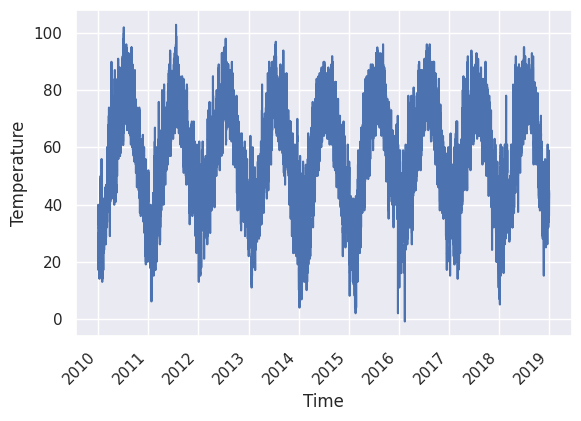

In [67]:
import matplotlib.pyplot as plt

# plot all the temperatures in NYC

temps.plot()
plt.ylabel("Temperature")
plt.xlabel("Time")
plt.xticks(rotation=45);

In [21]:
train_data = temps[:int(len(temps)*0.8)]             # choose 80% of the data in temps to be train_data
valid_data = temps[int(len(temps)*0.8):]             # choose the remaining 20% of the data to be valid_data

In [22]:
# double the check the number of rows in 'temps' (total dataset), train_data, valid_data

print(len(temps))

print(len(train_data))
print(len(valid_data))

77745
62196
15549


In [23]:
# check the first and the last date
# find the difference between the first and last dates

print(train_data.index[-1])
print(train_data.index[0])
print((train_data.index[-1] - train_data.index[0]).days)

2017-03-18 11:51:00
2010-01-01 00:51:00
2633


In [43]:
# test the mean of the temps in train_data

train_data.values.mean()

55.52824908354235

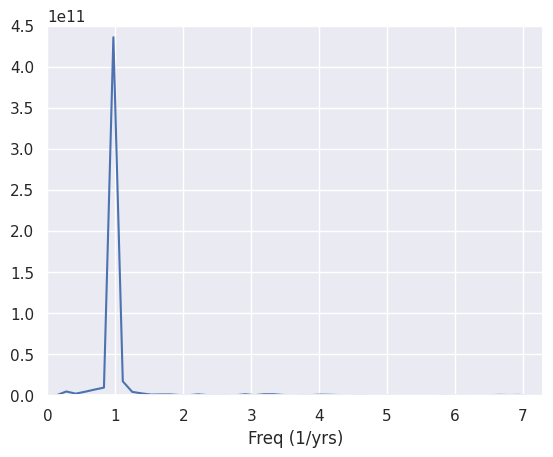

In [52]:
# preprocessing step in Fast Fourier Transform to center signal around zero.
# subtract the initial date from the final date. Get days from 'datetime' objects, divide by 365 to get years

fft_counts = np.fft.fft(train_data.values - train_data.values.mean())
yrs = (train_data.index[-1] - train_data.index[0]).days / 365.

plt.plot(np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0, 7.3, 0, 45e10])
plt.xlabel('Freq (1/yrs)');

In [51]:
# check the values of fft_counts (the result of Fast Fourier Transform)

print(f"fft_counts: {fft_counts}")
print()
print(f"number of fft_counts: {len(fft_counts)}")
print()
print(f"years: {yrs}")

fft_counts: [ 7.73070497e-11    +0.j          2.97504292e+03-11783.45919161j
 -5.46587082e+04+39945.25699j    ... -4.38230254e+04 -4675.31487046j
 -5.46587082e+04-39945.25699j     2.97504292e+03+11783.45919161j]

number of fft_counts: 62196

years: 7.213698630136986


In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import base


class IndexSelector(base.BaseEstimator, base.TransformerMixin):
    """Return indices of a data frame or Series for use in other estimators."""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index

class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, freq):
        self.freq = freq
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi * self.freq
        return np.c_[np.sin(dt), np.cos(dt)]

#union = FeatureUnion([('drift', QuadBackground()), 
#                      ('fourier_annual', FourierComponents(1/365))])

model_seasonality_fourier = Pipeline([
                                    ('fromdt', AdapterFunction()),
                       #             ('indices', IndexSelector()),
                                    ('fourier_annual', FourierComponents(1/365)),
                                    ('regressor', LinearRegression())
                                    ])

model_seasonality_fourier.fit(train_data, train_data.values)
plt.plot(train_data.index, train_data.values, 
         train_data.index, model_seasonality_fourier.predict(train_data))
plt.xticks(rotation=45);

KeyError: 'temp'

In [64]:
print("Train R^2:", model_seasonality_fourier.score(train_data, train_data.values))
print("Validation R^2:", model_seasonality_fourier.score(valid_data, valid_data.values))

Train R^2: 0.7641779288641962
Validation R^2: 0.7421928538388056


In [65]:
train_noise = train_data - model_seasonality_fourier.predict(train_data)

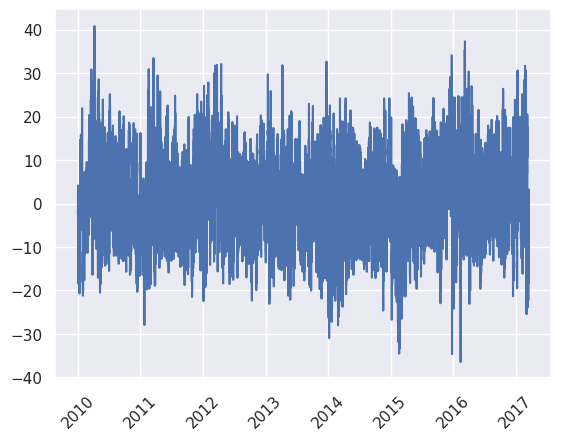

In [66]:
plt.plot(train_noise)
plt.xticks(rotation=45);

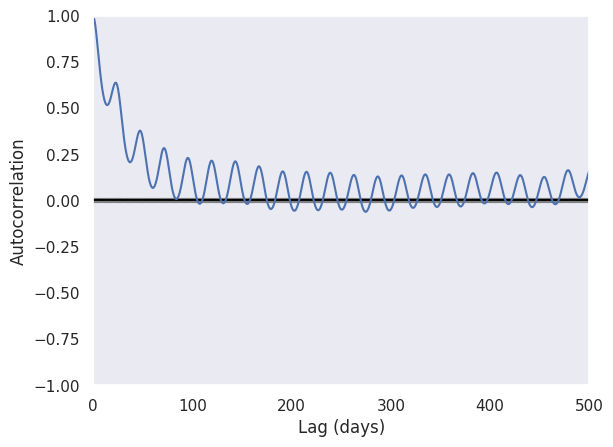

In [70]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(train_noise)
plt.xlabel('Lag (days)')
plt.xlim([0, 500]);

## Fourier model

Let's consider another way to deal with the seasonal terms.  Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be

$$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

where $y_0$ and $t_0$ are parameters to be learned and $T$ is the period - one year for seasonal variation, one day for daily, etc.  While this is linear in $y_0$, it is not linear in $t_0$. However, we know from Fourier analysis, that the above is
equivalent to

$$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

which is linear in $A$ and $B$.

Create a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.  Build a `fourier_factory` function that will return instances of this model.

In [ ]:
def fourier_factory():
    return ...

A general `GroupByEstimator` should be able to take the new factory function and build a model for each city.

In [82]:
fourier_model = season_model

Submit this model to the grader.

In [83]:
grader.score('ts__fourier_model', fourier_model.predict)

Your score: 0.9939


*Copyright &copy; 2022 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*